In [1]:
import torch
import lightning
from mlcolvar.cvs import BaseCV
from mlcolvar.core import FeedForward

import sys
torch.manual_seed(42)
torch.set_default_dtype(torch.float64)
sys.path.append("..")
from loss_and_models import *
from descriptors import *

In [2]:
import numpy as np
from mlcolvar.data import DictModule, DictDataset
from mlcolvar.utils.io import create_dataset_from_files, load_dataframe
import pandas as pd
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
opes = load_dataframe('/home/tdevergne@iit.local/Documents/generator_learning/alanine_datasets/psi/COLVAR_driver',
                      start=250000,stop=None, stride=1)

bias =np.loadtxt("/home/tdevergne@iit.local/Documents/generator_learning/alanine_datasets/psi/COLVAR")[250000:,-5]


/home/tdevergne@iit.local/anaconda3/envs/kooplearn-reborn/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [3]:

X = opes.filter(regex='p[0-9]\.[xyz]|p[0-9][0-9]\.[xyz]')
kT = 2.49432
logweights = bias / kT
dataset = DictDataset({"data":X[::70].values, "weights":np.exp(logweights[::70])})#30 2500 epochs


In [4]:
dataset["data"].shape

torch.Size([27086, 30])

In [5]:

datamodule = DictModule(dataset, lengths=[0.8,0.2],random_split=True,shuffle=True)



In [6]:
dataset["data"] = dataset["data"].to(device)
dataset["weights"] = dataset["weights"].to(device)

In [7]:
masses = np.array([12.011,12.011,15.999,14.0067,12.011,12.011,12.011,15.999,14.0067,12.011])
n_atoms = 10
gamma = 1/0.05
friction = np.zeros(n_atoms*3)
print(friction.shape)
for i_atom in range(10):
    friction[3*i_atom:3*i_atom+3] = np.array([kT / (gamma*masses[i_atom])]*3) 
cell = torch.Tensor([4.0,4.0,4.0]).to(device)
#cell = torch.ones(91*3).to(device)*3.961
friction = torch.tensor(friction, device=device)

(30,)


In [8]:

model_psi = torch.load("model_alanine_psi.pt").to(device)
model_phi = torch.load("model_alanine_phi.pt").to(device)
model_comm =  torch.jit.load('models/model_committor.pt').to(device)


In [9]:
opes_exp = load_dataframe('/home/tdevergne@iit.local/Documents/generator_learning/alanine_datasets/opes_exp/COLVAR_driver',
                      start=0,stop=None, stride=1)
bias = np.loadtxt('/home/tdevergne@iit.local/Documents/generator_learning/alanine_datasets/opes_exp/COLVAR')[:,-5]
opes_simple = load_dataframe('/home/tdevergne@iit.local/Documents/generator_learning/alanine_datasets/opes/COLVAR',
                      start=0,stop=None, stride=1)
X = opes_exp.filter(regex='p[0-9]\.[xyz]|p[0-9][0-9]\.[xyz]')
X_simple = opes_simple.filter(regex='p[0-9]\.[xyz]|p[0-9][0-9]\.[xyz]')
weights = np.exp(bias/kT)


In [10]:
distances =  opes_exp.filter(regex='x[0-9]|x[0-9][0-9]')

In [11]:
distances_tensor = torch.tensor(distances.values, dtype=torch.float32, device=device)
committor = model_comm(distances_tensor)

In [12]:
dataset["data"].shape

torch.Size([27086, 30])

In [14]:
from loss_and_models import compute_eigenfunctions

train_dataset_phi = DictDataset({"data":X[::2].values, "weights":weights[::2]})
valid_dataset_phi = DictDataset({"data":X.values, "weights":weights})
train_dataset_phi["data"] = train_dataset_phi["data"].to(device)
train_dataset_phi["weights"] = train_dataset_phi["weights"].to(device)
valid_dataset_phi["data"] = valid_dataset_phi["data"].to(device)
valid_dataset_phi["weights"] = valid_dataset_phi["weights"].to(device)

evals_psi, evecs_psi = compute_eigenfunctions(model_psi, dataset, friction, 0.05,3)
evals_phi, evecs_phi = compute_eigenfunctions(model_phi, train_dataset_phi, friction, 0.05,3)
g_psi_psi = model_psi(dataset["data"]) @ evecs_psi.real
g_psi_phi = model_psi(valid_dataset_phi["data"]) @ evecs_psi.real
g_phi_phi = model_phi(valid_dataset_phi["data"]) @ evecs_phi.real
model_phi = model_phi.to(device)
model_psi = model_psi.to(device)

In [15]:
g_psi_phi[:,2] =  2 * (g_psi_phi[:,2] - g_psi_phi[:,2].min()) / (g_psi_phi[:,2].max() - g_psi_phi[:,2].min()) - 1 
g_phi_phi[:,2] = 2 * (g_phi_phi[:,2] - g_phi_phi[:,2].min()) / (g_phi_phi[:,2].max() - g_phi_phi[:,2].min()) - 1
g_psi_phi[:,0] = 2 * (g_psi_phi[:,0] - g_psi_phi[:,0].min()) / (g_psi_phi[:,0].max() - g_psi_phi[:,0].min()) - 1
g_phi_phi[:,0] = 2 * (g_phi_phi[:,0] - g_phi_phi[:,0].min()) / (g_phi_phi[:,0].max() - g_phi_phi[:,0].min()) - 1

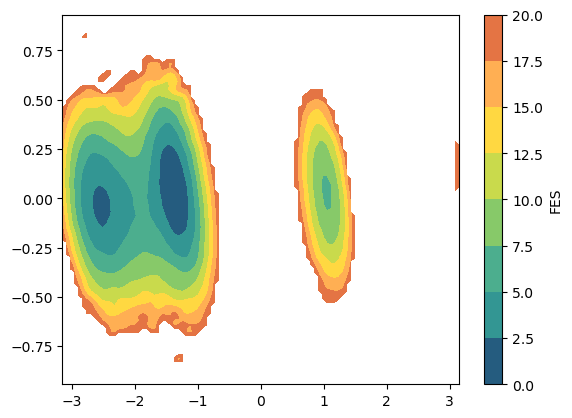

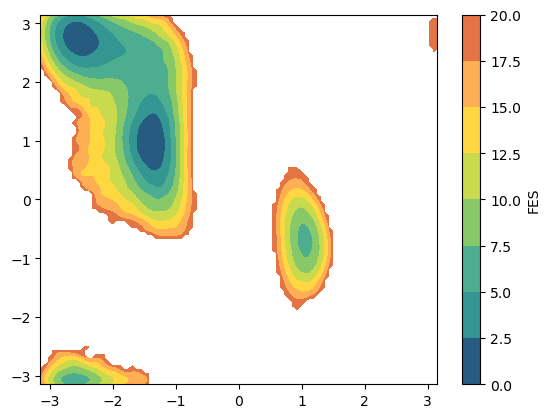

In [16]:
from mlcolvar.utils.fes import compute_fes
from mlcolvar.utils.plot import *
import matplotlib.pyplot as plt
fes_theta,grid_theta,bounds,error = compute_fes(np.stack((opes_exp["phi"].values,opes_exp["theta"])).swapaxes(1,0),
                                    weights=weights,
                                    blocks=1,
                                    bandwidth=0.01, scale_by='range',
                                    plot=True, plot_max_fes=20, eps=1e-10,temp=300)
fes_psi,grid_psi,bounds,error = compute_fes(np.stack((opes_exp["phi"].values,opes_exp["psi"])).swapaxes(1,0),
                                    weights=weights,
                                    blocks=1,
                                    bandwidth=0.01, scale_by='range',
                                    plot=True, plot_max_fes=20, eps=1e-10,temp=300)

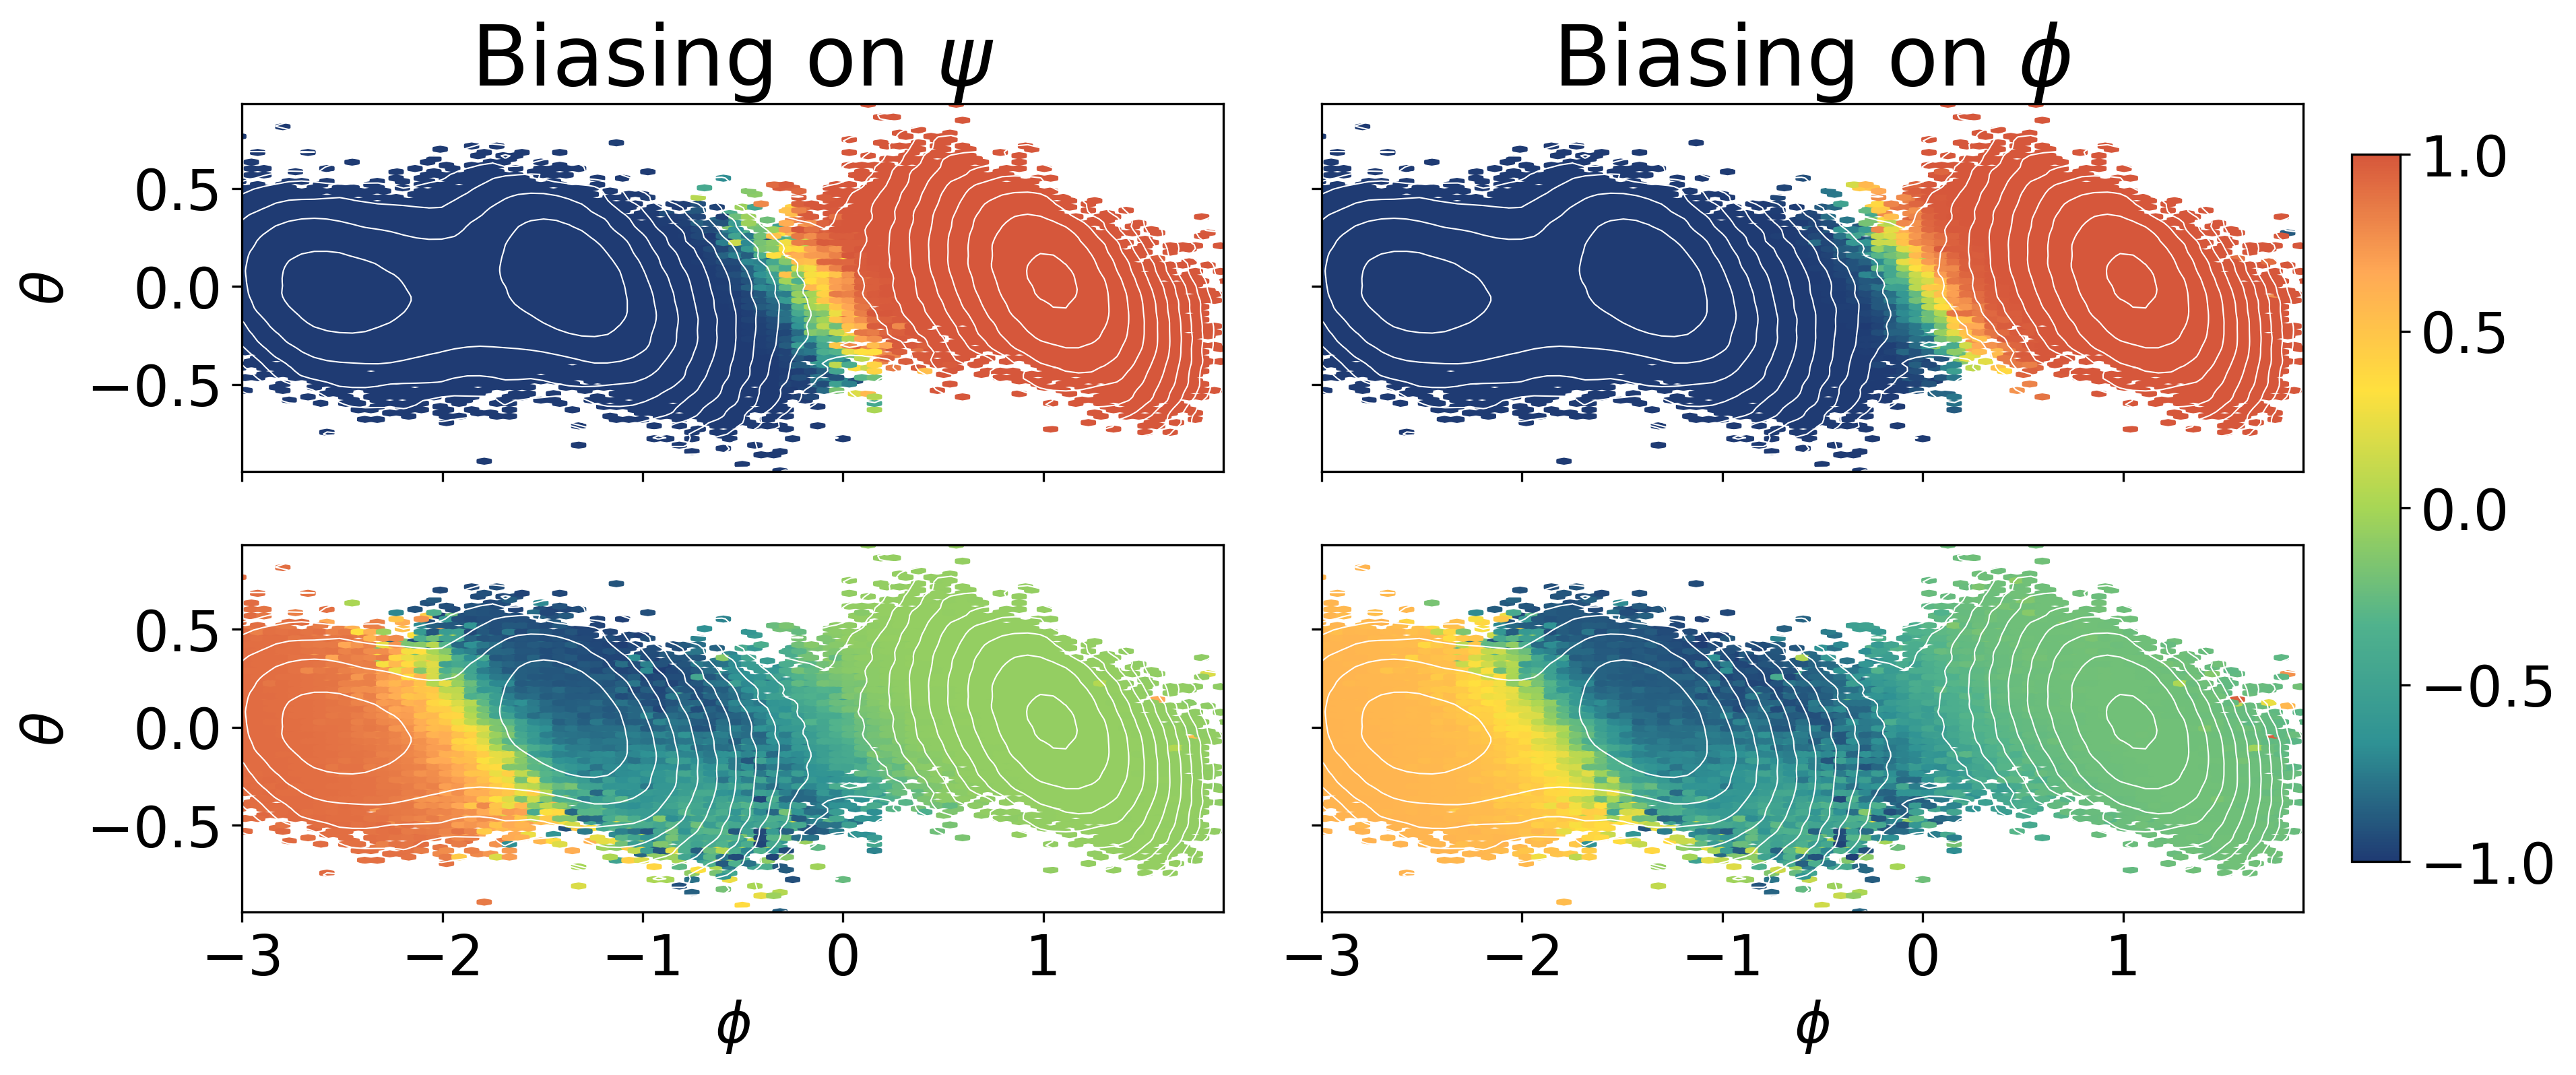

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming opes_exp, g_psi_phi, and g_phi_phi are defined

# Create a figure
fig, axs = plt.subplots(2, 2, figsize=(12, 5), sharex=True, sharey=True, dpi=300)

# Define the subplots
#axs = [fig.add_subplot(2, 2, 1), fig.add_subplot(2, 2, 2), 
#       fig.add_subplot(2, 2, 3), fig.add_subplot(2, 2, 4)]

# Colormap
cmap = "fessa"  # You can choose any colormap you like

# Gather all data to find global min and max for color normalization
all_data = [
    -g_psi_phi[:, 2].cpu().detach(),
    g_phi_phi[:, 2].cpu().detach(),
    -g_psi_phi[:, 0].cpu().detach(),
    g_phi_phi[:, 0].cpu().detach()
]
# Flatten the data and get min and max
all_values = np.concatenate([data.numpy() for data in all_data])
vmin = np.min(all_values)
vmax = np.max(all_values)

# Create hexbin plots with the same vmin and vmax
hb1 = axs[0,0].hexbin(opes_exp["phi"].values, opes_exp["theta"].values, 
                    C=-g_psi_phi[:, 2].cpu().detach(), cmap=cmap, vmin=vmin, vmax=vmax)
hb2 = axs[0,1].hexbin(opes_exp["phi"].values, opes_exp["theta"].values, 
                    C=g_phi_phi[:, 2].cpu().detach(), cmap=cmap, vmin=vmin, vmax=vmax)
hb3 = axs[1,0].hexbin(opes_exp["phi"].values, opes_exp["theta"].values, 
                    C=g_psi_phi[:, 0].cpu().detach(), cmap=cmap, vmin=vmin, vmax=vmax)
hb4 = axs[1,1].hexbin(opes_exp["phi"].values, opes_exp["theta"].values, 
                    C=g_phi_phi[:, 0].cpu().detach(), cmap=cmap, vmin=vmin, vmax=vmax)

# Create a single common colorbar outside of the subplots
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Adjust these values to control position and size
cbar = fig.colorbar(hb1, cax=cbar_ax, orientation='vertical')  
#cbar.set_label('Color intensity', fontsize=10)
cbar.ax.tick_params(labelsize=20)
# Set axis labels

axs[0,0].set_ylabel(r"$\theta$", fontsize=20)

axs[1,0].set_ylabel(r"$\theta$", fontsize=20)
for ax in axs[1]:  # Bottom row
    ax.set_xlabel(r"$\phi$", fontsize=20)

# Add white contours to each plot with thin lines
for arr in axs:
    for ax in arr:
        ax.contour(grid_theta[0], grid_theta[1], fes_theta, levels=20, colors='white', linewidths=0.5)
        ax.tick_params(axis='both', which='major', labelsize=20)
        ax.set_xlim(-3,1.9)


# Titles for each plot
titles = ["Biasing on $\psi$", "Biasing on $\phi$"]
for ax, title in zip(axs[0], titles):
    ax.set_title(title,fontsize=30)

# Adjust layout to reduce white space
plt.subplots_adjust(left=0.05, right=0.9, top=0.9, bottom=0.1, hspace=0.2, wspace=0.1)
plt.show()